**About the data**

This data was a featured kaggle code competition under the name of 
Tweet Sentiment Extraction (Extract support phrases for sentiment labels). Link to the code can be found here https://www.kaggle.com/c/tweet-sentiment-extraction/overview


Objective: 
Predicting sentiment base on phrase. 



Columns:
1. textID - unique ID for each piece of text
2. text - the text of the tweet
3. sentiment - the general sentiment of the tweet
4. selected_text - [train only] the text that supports the tweet's sentiment


Files needed:
1. train.csv - the training set
2. test.csv - the test set



Table of content

1. Import libraries and datasets 
2. EDA
3. Data Preprocessing for models 
5. Transfer Learning using 3 Neural-Net Language Models (NNLM) pre-train models.
6. Evaluation, Performance and comparison of all 3 models, also see how performance change when models are fine tuned. 

Import Libraries 

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import utils
from sklearn import preprocessing

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display
import seaborn as sns
from collections import Counter

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [2]:
# load training datasets 
train_df = pd.read_csv('train.csv')
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
# load test datasets
test_df = pd.read_csv('test.csv')
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


EDA 

Training dataset sentiment breakdown
neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


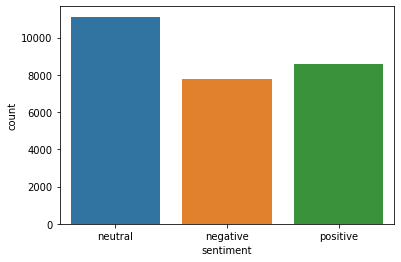

In [4]:
# find and visualize the distribution of target variable which is the 'sentiment' column 
# for both training and test subsets

print('Training dataset sentiment breakdown')
print(train_df.sentiment.value_counts())
sns.countplot(train_df["sentiment"])


Testing dataset sentiment breakdown
neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


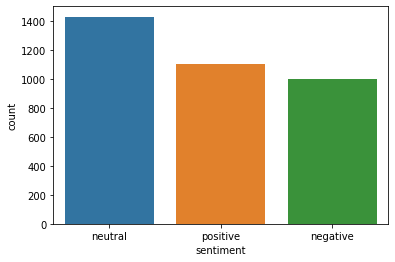

In [5]:
print('Testing dataset sentiment breakdown')
print(test_df.sentiment.value_counts())
sns.countplot(test_df["sentiment"])

Anaysis: 


As we can see for both training and testing data neutral tweets have the higher volume and negative and positive tweets being roughly close to one another.

In [6]:
train_df['Num_word_text'] = train_df['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text for training dataset
test_df['Num_word_text'] = test_df['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text for testing dataset
print('Max length in main text for training:',train_df['Num_word_text'].max())
print('Mean length in main text for training:',train_df['Num_word_text'].mean())
print('Min length in main text for training:',train_df['Num_word_text'].min())
print('Max length in main text for testing:',test_df['Num_word_text'].max())
print('Mean length in main text for testing:',test_df['Num_word_text'].mean())
print('Min length in main text for testing:',test_df['Num_word_text'].min())

Max length in main text for training: 33
Mean length in main text for training: 12.902441686983734
Min length in main text for training: 1
Max length in main text for testing: 32
Mean length in main text for testing: 12.763157894736842
Min length in main text for testing: 1


In [7]:
# most common words in the 'text' column from training data 
train_df['temp_list'] = train_df['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,to,5190
1,I,4842
2,the,4303
3,a,3427
4,my,2503
5,i,2298
6,and,2164
7,you,2072
8,is,1944
9,in,1864


Data Preprocessing 

In [8]:
# for the independent variable aka the predictor variable we will use the 'text' column only 
# for this analysis
x_train = np.array(train_df['text'].to_list())
x_train = tf.convert_to_tensor(x_train)
y_train = train_df['sentiment'].values
x_test = test_df['text'].values
y_test = test_df['sentiment'].values
print(x_train)
print(y_train)
print(x_test)
print(y_test)

tf.Tensor(
[b' I`d have responded, if I were going'
 b' Sooo SAD I will miss you here in San Diego!!!'
 b'my boss is bullying me...' ...
 b' Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx'
 b' But it was worth it  ****.'
 b'   All this flirting going on - The ATG smiles. Yay.  ((hugs))'], shape=(27481,), dtype=string)
['neutral' 'negative' 'negative' ... 'positive' 'positive' 'neutral']
['Last session of the day  http://twitpic.com/67ezh'
 ' Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China:  (SH)  (BJ).'
 'Recession hit Veronique Branquinho, she has to quit her company, such a shame!'
 ...
 ' I know what you mean. My little dog is sinking into depression... he wants to move someplace tropical'
 '_sutra what is your next youtube video gonna be about? I love your videos!'
 ' http://twitpic.com/4woj2 - omgssh  ang cute ng bby.!']
['neutral' 'positive' 'negative' ... 'negative' 'positive

In [9]:
# we will need to label encoder the target varible than convert to one hot rep categories 
endcoder = preprocessing.LabelEncoder()

y_train = endcoder.fit_transform(y_train)
y_test = endcoder.fit_transform(y_test)

num_c = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_c)
y_test = utils.to_categorical(y_test, num_c)

In [10]:
# print shapes 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)
print(x_train)

(27481,)
(3534,)
(27481, 3)
(3534, 3)
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]
tf.Tensor(
[b' I`d have responded, if I were going'
 b' Sooo SAD I will miss you here in San Diego!!!'
 b'my boss is bullying me...' ...
 b' Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx'
 b' But it was worth it  ****.'
 b'   All this flirting going on - The ATG smiles. Yay.  ((hugs))'], shape=(27481,), dtype=string)


Transfer Learning using TensorFlow Hub

All 3 pre-train models I wil use are all Neural-Net Language Model (NNLM) with dimensions of 20, 50 and 128. 

To use pre-train models from tensorflow all you will need is the link to the models than use the hub.KerasLayer(link, input_shape, output_shape, dtype) 

For more instructions check out https://tfhub.dev to see all pre-train tensorflow models and how to use them.


In [26]:
# links 
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1" ] {allow-input: true}

In [11]:

def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer=hub.KerasLayer(module_url,input_shape=[],output_shape=[embed_size],dtype=tf.string,trainable=trainable)
  model = tf.keras.models.Sequential([
                                     hub_layer,
                                     tf.keras.layers.Dense(256, activation='relu'),
                                     tf.keras.layers.Dense(128, activation = 'relu'), 
                                     tf.keras.layers.Dropout(.2), 
                                     tf.keras.layers.Dense(3, activation='sigmoid')

  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  # training will stop once the minmum val_loss doesn't imporve for 2 epochs 
  
  history=model.fit(x_train,y_train, epochs=100,batch_size=32,validation_data=(x_test,
                    y_test),callbacks=[tfdocs.modeling.EpochDots(),
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min'), 
                    tf.keras.callbacks.TensorBoard(logdir/name)],verbose=0)
  return history
                                

In [12]:
# dic for the 6 models to be places in, 3 times when the trainable=True for all 3 pre-train models and 3 times when the trainable=False 
histories = {}

In [29]:
histories['nnlm-en-dim128-FINETUNE'] = train_and_evaluate_model(module_url, embed_size=128, 
                                                                    name='nnlm-en-dim128-FINETUNE',
                                                                    trainable=True)


Epoch: 0, accuracy:0.5417,  loss:0.9512,  val_accuracy:0.6316,  val_loss:0.8038,  
....

In [30]:
histories

{'gnews-swivel-20dim': <keras.callbacks.History at 0x7f61503f8610>,
 'gnews-swivel-20dim-FINETUNE': <keras.callbacks.History at 0x7f60e2d86d10>,
 'nnlm-en-dim128': <keras.callbacks.History at 0x7f60e2607490>,
 'nnlm-en-dim128-FINETUNE': <keras.callbacks.History at 0x7f60e2d80b90>,
 'nnlm-en-dim50': <keras.callbacks.History at 0x7f60e2bf71d0>,
 'nnlm-en-dim50-FINETUNE': <keras.callbacks.History at 0x7f60e2883650>}

Evaluation/Performance

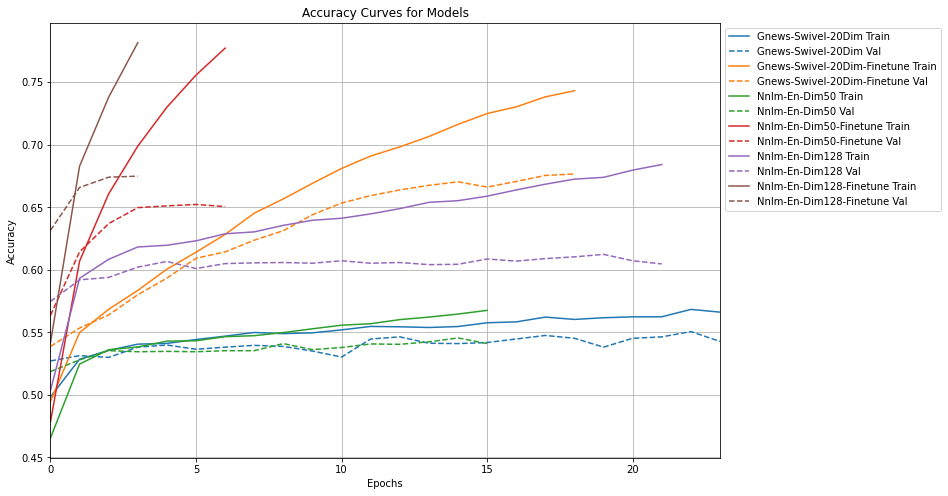

In [31]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

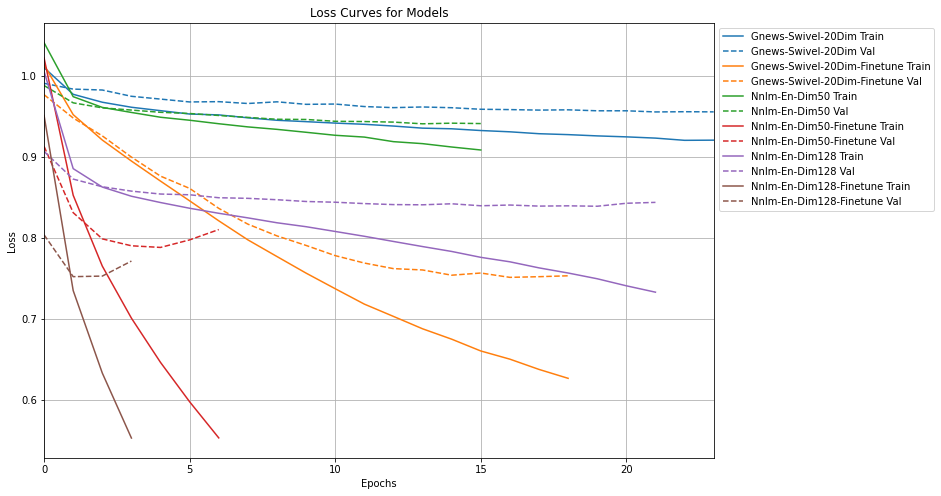

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

Finding: 
1. On the accuracy curve graph, "Nnlm-EN-Dim128-Finetune Val" has the highest accuracy on the validation data.
2. On the accuracy curve graph, "Nnlm-EN-Dim128-Finetune Train" had the highest accuracy on the training data. 
3. A trend we see on the accuracy curve graph is that the higher the embedding dimensions the higher the accuracy score. 
4. On the loss curve graph, a similar trend is seen as the higher the embedding dimensions the lower the loss score. 
5. Also, another key finding is that the fine-tune models perform better than models that aren't fine-tuned. 